<h1> MBA Analysis V2</h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/3/22</h7>

In [275]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline


print('Executed')

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Executed


In [276]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [ ]:
from IPython.display import HTML

def hide_code():
	return HTML('''<script>
	code_show=true; 
	function code_toggle() {
	 if (code_show){
	 $("div.input").hide();
	 } else {
	 $("div.input").show();
	 }
	 code_show = !code_show
	} 
	$( document ).ready(code_toggle);
	</script>
	The raw code for this IPython notebook is by default hidden for easier reading.
	To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')
@afreund415
 


<h3> Initial BigQuery SQL Speed Queries </h3>
<p>IPv4 with multiple concurrent TCP connections</p>

<h5>Download Queries and Dataframes</h5>

In [269]:
# DOWNLOAD***

peak_download_sql = """
SELECT
    mt_Download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(4)] as low_4_percent_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
(SELECT
    mt.download as mt_download,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httpmt.bytes_sec as httpmt_bytes_sec,
    httpmt.unit_id as httpmt_unit_id,
    PERCENTILE_CONT(httpmt.bytes_sec,.01) over (PARTITION BY httpmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httpmt.bytes_sec,.99) over (PARTITION BY httpmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httpgetmt` as httpmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
)   
Where httpmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY download_service_tier, ISP, tech
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY download_service_tier, ISP, tech

"""

fullDay_download_sql = """
SELECT
    mt_Download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
(SELECT
    mt.download as mt_download,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httpmt.bytes_sec as httpmt_bytes_sec,
    httpmt.unit_id as httpmt_unit_id,
    PERCENTILE_CONT(httpmt.bytes_sec,.01) over (PARTITION BY httpmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httpmt.bytes_sec,.99) over (PARTITION BY httpmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httpgetmt` as httpmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt ON httpmt.unit_id=mt.Unit_ID
)   
Where httpmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY download_service_tier, ISP, tech
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY download_service_tier, ISP, tech

"""







# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")

Executed


<h5>Upload Queries and Dataframes</h5>

In [270]:
# ***UPLOAD***


peak_upload_sql = """
SELECT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httppmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httppmt_bytes_sec/125000) as max_Mbps,
    MIN(httppmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httppmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt_unit_id) as total_boxes
FROM
(select
    mt.upload as mt_upload,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httppmt.bytes_sec as httppmt_bytes_sec,
    httppmt.unit_id as httppmt_unit_id,
    PERCENTILE_CONT(httppmt.bytes_sec,.01) over (PARTITION BY httppmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httppmt.bytes_sec,.99) over (PARTITION BY httppmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httppostmt` as httppmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httppmt.unit_id=mt.Unit_ID
    WHERE (EXTRACT(HOUR FROM httppmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httppmt.dtime) <=23)
)   
Where httppmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY upload_service_tier, ISP, tech
HAVING COUNT(DISTINCT httppmt_unit_id) > 9
ORDER BY upload_service_tier, ISP, tech
"""

fullDay_upload_sql = """
SELECT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httppmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httppmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httppmt_bytes_sec/125000) as max_Mbps,
    MIN(httppmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httppmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httppmt_unit_id) as total_boxes
FROM
(select
    mt.upload as mt_upload,
    mt.isp as mt_isp,
    mt.technology as mt_technology,
    httppmt.bytes_sec as httppmt_bytes_sec,
    httppmt.unit_id as httppmt_unit_id,
    PERCENTILE_CONT(httppmt.bytes_sec,.01) over (PARTITION BY httppmt.bytes_sec) as bottom_1_pct,
    PERCENTILE_CONT(httppmt.bytes_sec,.99) over (PARTITION BY httppmt.bytes_sec) as top_1_pct
    FROM
      `broadband-data.mba_data.curr_httppostmt` as httppmt
    INNER JOIN
      `broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httppmt.unit_id=mt.Unit_ID
)   
Where httppmt_bytes_sec between bottom_1_pct and top_1_pct
GROUP BY upload_service_tier, ISP, tech
HAVING COUNT(DISTINCT httppmt_unit_id) > 9
ORDER BY upload_service_tier, ISP, tech

"""



peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


In [13]:
peak_download 

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,1.5,CenturyLink,DSL,1.210811,1.235744,0.671032,1.493808,1.064696,0.611152,1.934584,0.022072,0.257870,65
1,3.0,CenturyLink,DSL,2.850792,2.832320,1.484872,4.766320,2.205512,1.429000,5.404400,0.016840,0.897564,50
2,3.0,Comcast,Cable,3.511462,3.556472,3.279112,3.577728,3.540504,3.268904,3.607728,0.262824,0.230169,10
3,3.0,Frontier,DSL,2.425750,2.632312,1.198840,3.585376,1.706096,1.172032,3.998760,0.276048,0.724883,24
4,3.0,Verizon DSL,DSL,2.022737,2.307192,0.570384,2.804664,1.206728,0.531680,2.846840,0.115192,0.724003,23
5,3.0,Windstream,DSL,2.598924,2.665840,0.547472,3.546224,2.091560,0.533992,4.398760,0.020112,0.863872,15
6,4.0,Windstream,DSL,4.015566,4.367472,2.188920,4.414664,3.827016,2.066928,4.609920,0.305016,0.728208,18
7,5.0,Cincinnati Bell,DSL,3.735885,4.216632,1.242880,4.329480,3.228968,1.103880,41.034560,0.249400,1.448880,49
8,6.0,Frontier,DSL,5.444390,5.683616,1.770888,7.892512,4.402104,1.521736,9.551024,0.443104,1.713407,36
9,6.0,Windstream,DSL,5.987729,5.984448,4.743992,6.866808,5.793120,4.565424,6.946528,0.211760,0.729300,10


In [7]:
fullDay_download

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,1.5,CenturyLink,DSL,1.245270,1.249120,0.774280,1.523976,1.113936,1.964504,0.002232,0.245167,65
1,3.0,CenturyLink,DSL,2.995939,2.870304,1.837240,4.902648,2.375344,9.895568,0.005592,0.980693,50
2,3.0,Comcast,Cable,3.504590,3.557408,3.187368,3.579376,3.536304,3.683936,0.262824,0.201568,10
3,3.0,Frontier,DSL,2.541429,2.774216,1.217840,3.619992,1.769784,4.002112,0.274936,0.747847,24
4,3.0,Verizon DSL,DSL,2.195570,2.411232,0.860840,2.809232,1.439720,2.869192,0.005584,0.667580,23
5,3.0,Windstream,DSL,2.721502,2.789664,0.566216,4.077464,2.308312,4.675856,0.020112,0.816491,15
6,4.0,Windstream,DSL,4.093838,4.373088,2.500536,4.421832,3.961888,4.756280,0.305016,0.651890,18
7,5.0,Cincinnati Bell,DSL,3.710901,4.235648,1.277056,4.711592,2.961408,41.747272,0.110608,1.217759,49
8,6.0,Frontier,DSL,5.944643,5.823288,3.547376,8.658544,5.077136,9.565984,0.006696,1.439046,36
9,6.0,Windstream,DSL,5.975018,5.965184,4.942840,6.856776,5.781888,6.946528,0.211760,0.690536,10


In [8]:
peak_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.256,CenturyLink,DSL,0.192903,0.203536,0.099544,0.244552,0.150984,0.471552,0.027848,0.058068,20
1,0.384,Frontier,DSL,0.507050,0.554656,0.149840,0.697880,0.345584,0.737888,0.135312,0.183899,13
2,0.512,CenturyLink,DSL,0.268957,0.216960,0.115192,0.530584,0.156576,0.778400,0.048608,0.145785,51
3,0.640,CenturyLink,DSL,0.620457,0.632440,0.463008,0.763768,0.529000,0.839800,0.139792,0.097842,22
4,0.750,CenturyLink,DSL,0.647166,0.675512,0.204672,0.850456,0.589400,1.014456,0.037072,0.160779,34
5,0.768,CenturyLink,DSL,0.695408,0.696640,0.503280,0.877360,0.613936,1.058768,0.157696,0.107424,55
6,0.768,Cincinnati Bell,DSL,0.556630,0.565896,0.403720,0.656512,0.515488,2.780680,0.079400,0.110251,49
7,0.768,Frontier,DSL,0.543533,0.618712,0.197944,0.710088,0.369184,0.752800,0.174464,0.173656,13
8,0.768,Verizon DSL,DSL,0.542049,0.583776,0.322096,0.721680,0.388224,0.759392,0.184320,0.131573,29
9,0.768,Windstream,DSL,0.630953,0.620704,0.354816,0.860480,0.559184,1.044064,0.035792,0.144965,65


In [9]:
fullDay_upload

,upload_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
0,0.256,CenturyLink,DSL,0.190928,0.203528,0.101776,0.248280,0.147624,0.493216,0.018472,0.055637,20
1,0.384,Frontier,DSL,0.532650,0.571720,0.200184,0.698992,0.354528,0.737888,0.070448,0.167175,13
2,0.512,CenturyLink,DSL,0.329353,0.298600,0.119656,0.664584,0.177320,0.778400,0.031280,0.164379,51
3,0.640,CenturyLink,DSL,0.635622,0.641952,0.473080,0.785912,0.561432,0.869752,0.123016,0.095204,22
4,0.750,CenturyLink,DSL,0.669256,0.687808,0.228776,0.904624,0.598344,1.014456,0.003352,0.161193,35
5,0.768,CenturyLink,DSL,0.681091,0.688928,0.496560,0.855568,0.600312,1.140792,0.045872,0.105969,56
6,0.768,Cincinnati Bell,DSL,0.556223,0.567016,0.395912,0.660432,0.517808,2.822952,0.071576,0.102139,49
7,0.768,Frontier,DSL,0.504064,0.547920,0.194584,0.708936,0.276240,0.773712,0.128616,0.180918,13
8,0.768,Verizon DSL,DSL,0.556334,0.596104,0.335400,0.721368,0.435456,0.813072,0.143152,0.131159,29
9,0.768,Windstream,DSL,0.652364,0.633008,0.395904,0.867544,0.573720,1.125816,0.035792,0.141902,66


<h2>Boxplots for Peak-Download for Download Tiers 1.5-25 Mbps</h2>

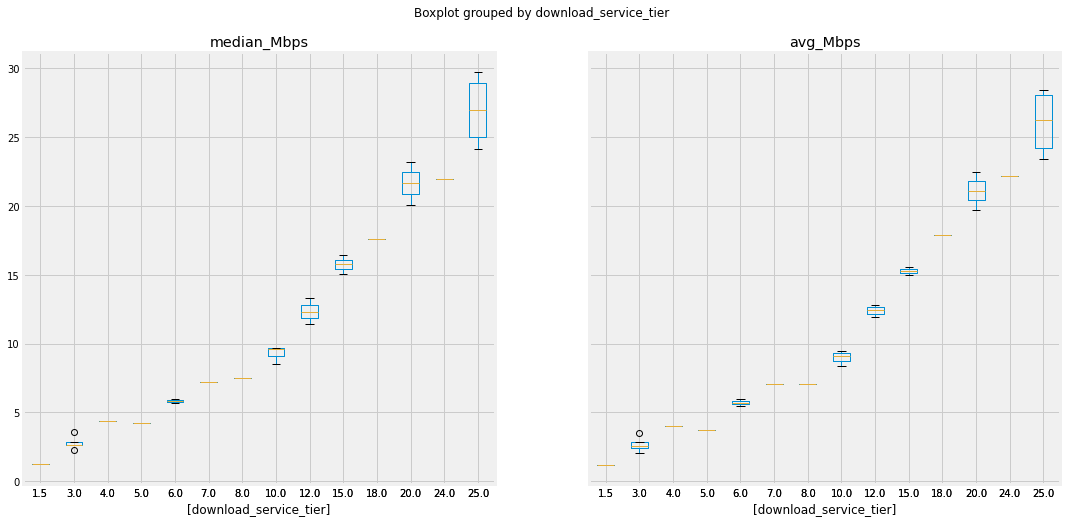

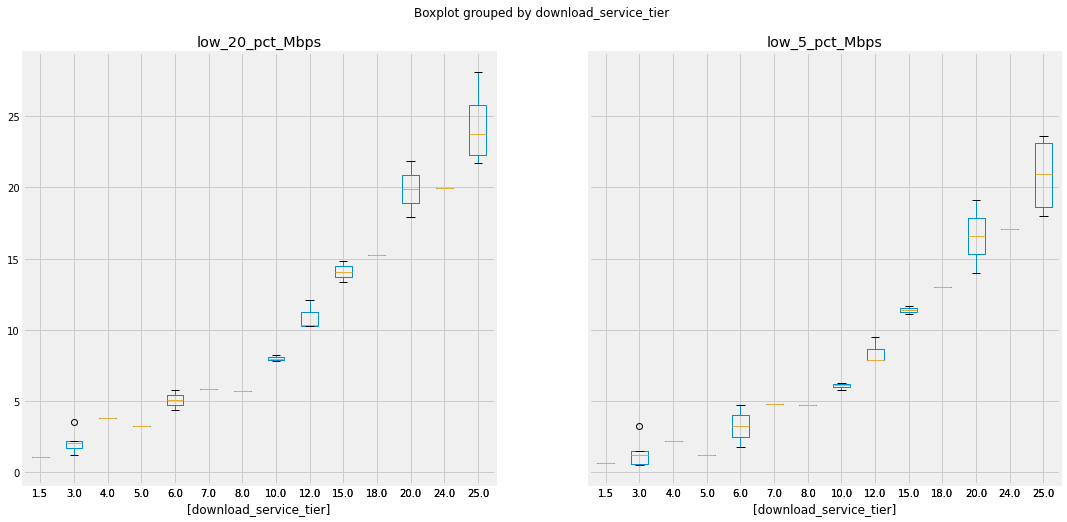

In [252]:
lower_tier_peak = peak_download.where(peak_download.download_service_tier <= 25 )
# tier_avgs = peak_download.groupby(['download_service_tier']).mean()
# peak_download.index.name = None
baseBoxplots = lower_tier_peak.boxplot(column = ['median_Mbps', 'avg_Mbps'], 
                                              by=['download_service_tier'], 
                                              figsize = (18,8))

                                              
altBoxplots = lower_tier_peak.boxplot(column = ['low_20_pct_Mbps', 'low_5_pct_Mbps'], 
                                              by=['download_service_tier'], 
                                              figsize = (18,8))                                            





<h2>Boxplots for Peak-Download for Download Tiers 30-1000 Mbps</h2>


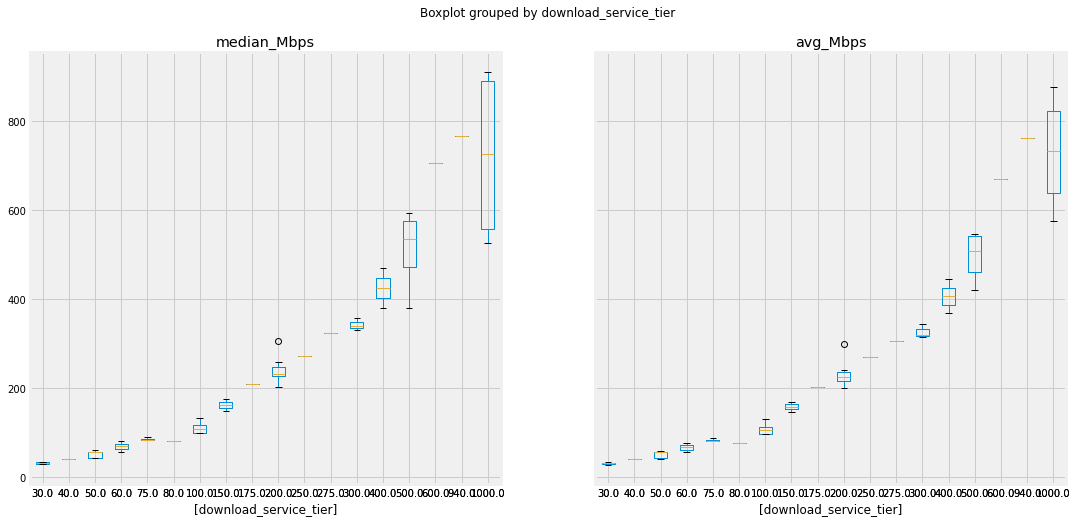

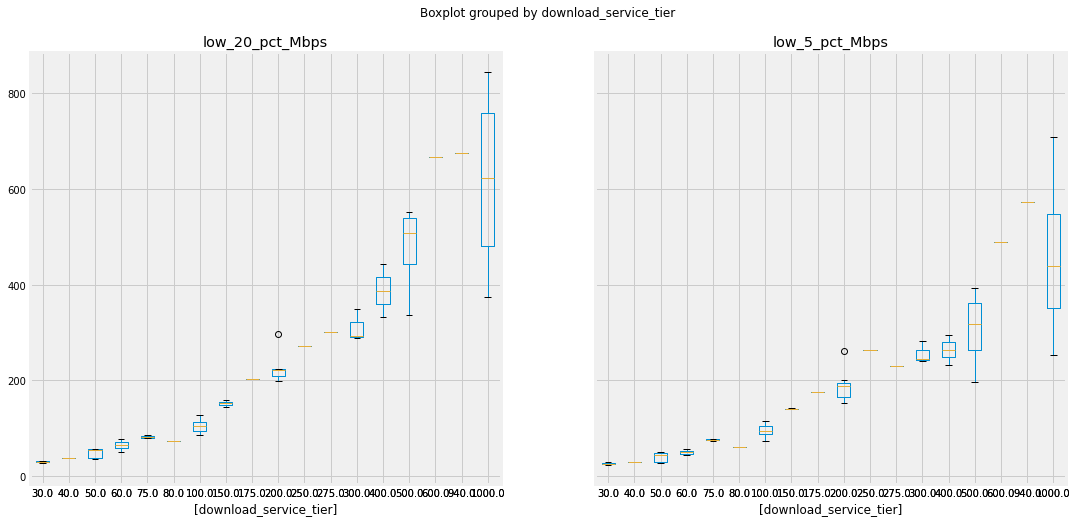

In [253]:
higher_tier_peak = peak_download.where(peak_download.download_service_tier > 25)
peak_download.index.name = None
higher_tier_boxplots = higher_tier_peak.boxplot(column = ['median_Mbps', 'avg_Mbps'], 
                                              by=['download_service_tier'], 
                                              figsize = (18,8))

                                              
altmetrics_boxplots = higher_tier_peak.boxplot(column = ['low_20_pct_Mbps', 'low_5_pct_Mbps'], 
                                              by=['download_service_tier'], 
                                              figsize = (18,8))           

<h2>Charts w/ average summary stats grouped by download tier and technology</h2>

<h5> Peak vs full-day download metrics for Cable

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,,
3.0,3.511462,3.556472,3.279112,3.577728,3.540504,3.268904,3.607728,0.262824,0.230169,10.0
20.0,22.475906,23.200584,19.106240,23.393872,21.879872,18.456072,23.426824,13.530976,1.485526,18.0
25.0,28.419018,29.699632,23.594880,29.793208,28.107944,22.795736,30.241992,0.197568,3.709781,57.0
30.0,33.406116,33.992152,28.752320,36.711248,32.672616,27.964504,36.838632,8.925848,2.679959,20.0
50.0,57.307973,59.458240,44.814584,59.744368,57.649592,42.935088,60.179224,5.741080,5.338524,58.0
60.0,71.867807,74.961280,53.415572,75.230152,71.910984,48.867748,89.094036,2.594800,9.629904,32.5
75.0,86.883362,88.877400,78.446848,89.412880,85.196984,77.271472,89.875416,26.249472,4.915926,42.0
100.0,117.357441,120.026770,104.537696,121.448156,116.210858,101.958864,128.513112,7.946312,10.036083,48.5
150.0,168.244795,175.367824,141.422848,179.172520,159.582456,136.403968,192.208792,0.048608,18.396937,47.0


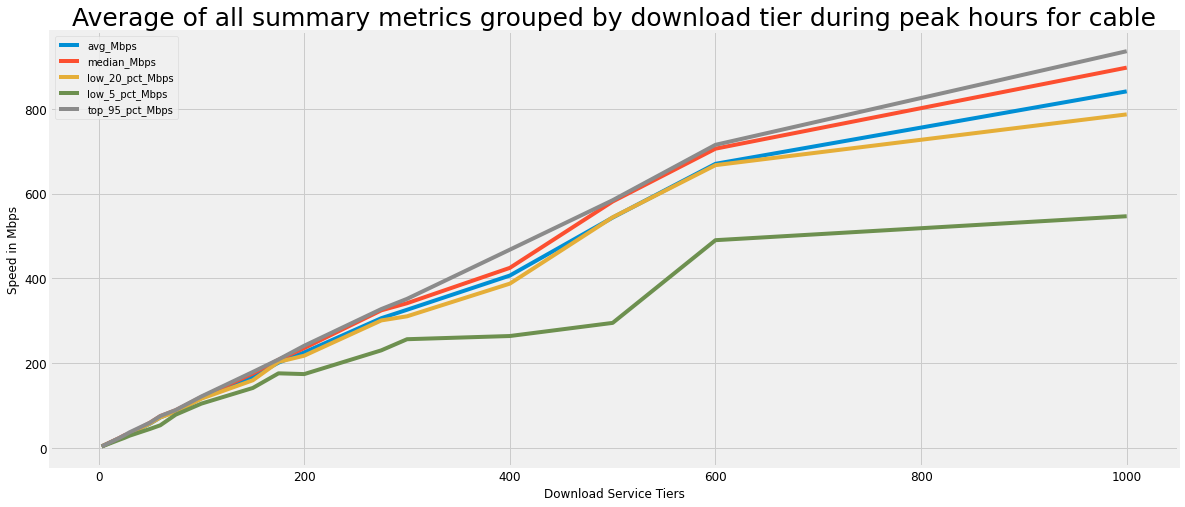

In [264]:
chartData = peak_download.where(peak_download.tech == 'Cable').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for cable', fontsize=25)
chartData


,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,
3.0,3.504590,3.557408,3.187368,3.579376,3.536304,3.683936,0.262824,0.201568,10.000000
20.0,22.797165,23.328320,20.191288,23.406920,22.681760,23.566928,10.126992,1.329264,18.000000
25.0,28.856753,29.721936,25.040440,29.798936,29.013632,30.241992,0.197568,3.027232,57.000000
30.0,33.880135,34.242344,29.319760,36.685192,33.621696,36.946680,2.164048,2.318309,20.000000
50.0,57.418660,59.490008,43.015432,59.780216,58.381152,60.371520,0.340776,5.403552,58.000000
60.0,72.542167,75.031844,60.697840,82.612956,73.927960,90.384808,0.916588,10.314393,32.500000
75.0,87.776968,89.163696,82.080744,89.418240,87.839624,91.241448,2.980912,5.015997,42.000000
100.0,118.353739,120.345560,106.500344,121.514006,118.292640,129.429358,1.901746,8.391771,49.000000
150.0,168.225947,175.964648,143.482968,179.185904,156.399368,193.030280,0.048608,18.185553,48.000000


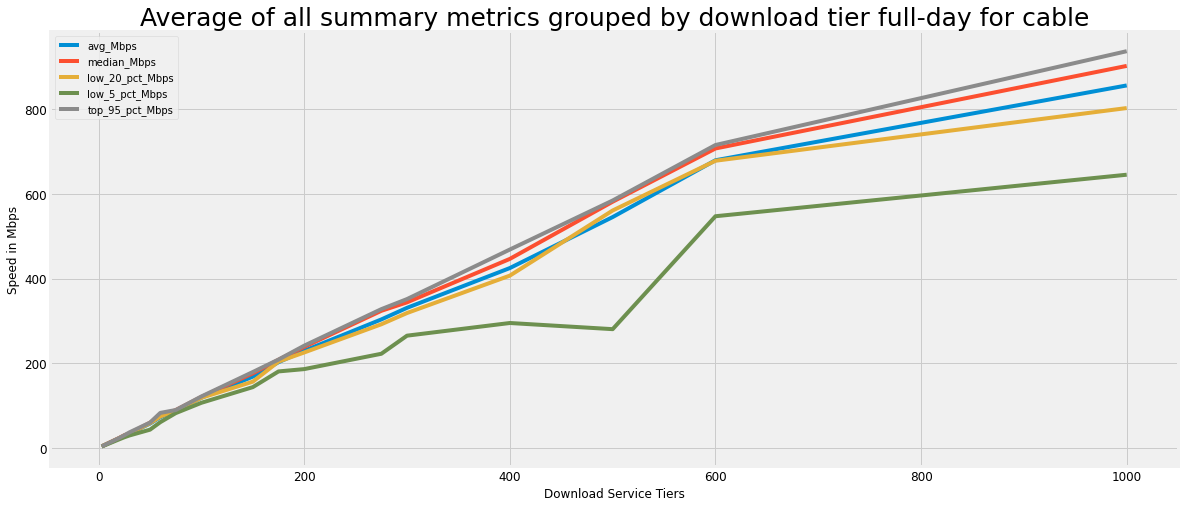

In [278]:
chartData = fullDay_download.where(fullDay_download.tech == 'Cable').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for cable', fontsize=25)
chartData


<h5> Peak vs full-day download metrics for Fiber

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,,
50.0,55.815540,56.933688,49.900600,57.236872,55.206048,48.636012,65.501016,23.396012,2.757140,38.5
75.0,80.841834,82.008316,74.599420,82.966984,80.107828,73.645220,88.821500,10.092572,4.226503,46.5
100.0,98.045371,99.510636,91.638104,100.148660,97.006620,90.772876,101.950444,39.134628,4.060608,59.5
150.0,146.912836,149.071328,139.318656,149.934440,144.469352,138.179944,152.381424,0.125136,7.606402,25.0
200.0,249.143214,253.175676,225.557108,255.726420,247.050292,223.150400,256.813080,111.226828,11.835106,29.0
250.0,269.268102,272.223464,262.790272,272.562752,270.963152,259.957808,353.850472,93.818320,14.144957,42.0
500.0,447.878028,441.085268,317.764320,527.323816,407.259904,304.618512,558.254904,57.599936,90.160851,105.0
940.0,762.927242,766.347776,571.683432,926.081928,675.475416,553.204648,932.462456,66.296056,110.348363,93.0
1000.0,616.365070,546.675960,373.408736,883.338316,444.985508,361.752488,927.467380,163.565244,186.305384,45.5


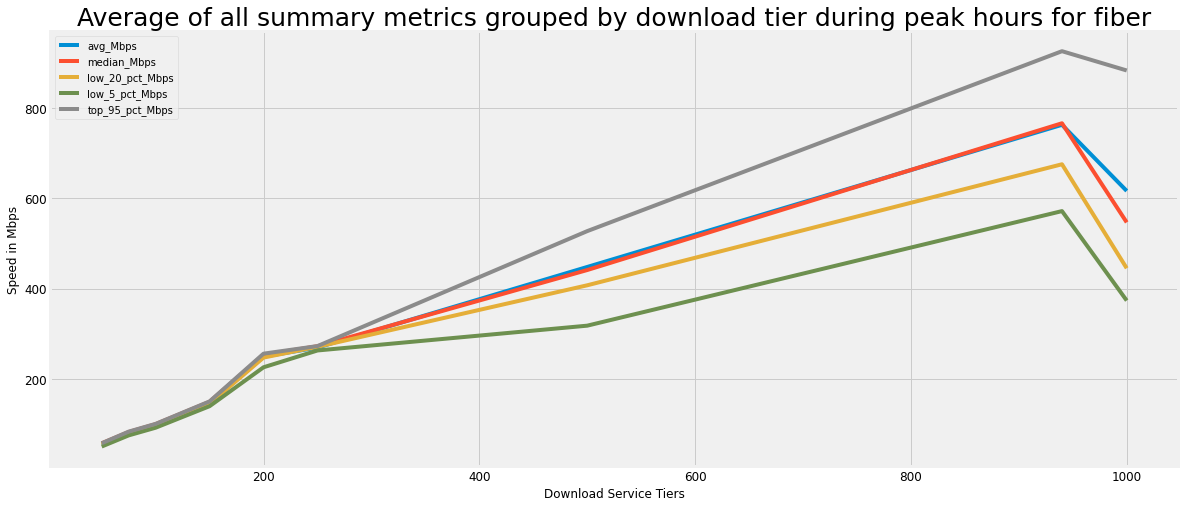

In [266]:
chartData = peak_download.where(peak_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for fiber', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,
50.0,56.104621,56.951648,50.929720,57.238448,56.282112,65.576364,15.581096,2.461790,39.0
75.0,81.336204,82.075864,76.711596,83.009952,81.109484,88.845268,6.442404,3.480771,46.5
100.0,98.806475,99.772760,93.670868,100.478796,98.613132,102.136580,24.997652,3.006103,60.0
150.0,147.958061,149.364760,142.376696,150.281936,147.770264,153.086344,0.061504,6.514487,25.0
200.0,250.139715,253.897176,228.192400,255.769148,250.503892,257.968856,23.327284,12.273768,29.0
250.0,268.702963,272.236504,259.466384,272.563000,271.319128,369.846496,86.450560,15.935389,42.0
500.0,456.969827,442.851232,342.795888,527.438328,416.087564,558.736712,10.262200,79.913855,105.5
940.0,770.748348,778.049352,579.106952,926.691944,692.941680,934.983608,30.384576,105.524526,94.0
1000.0,625.793381,556.447024,377.387532,885.420888,448.683172,928.408992,27.178480,187.904081,45.5


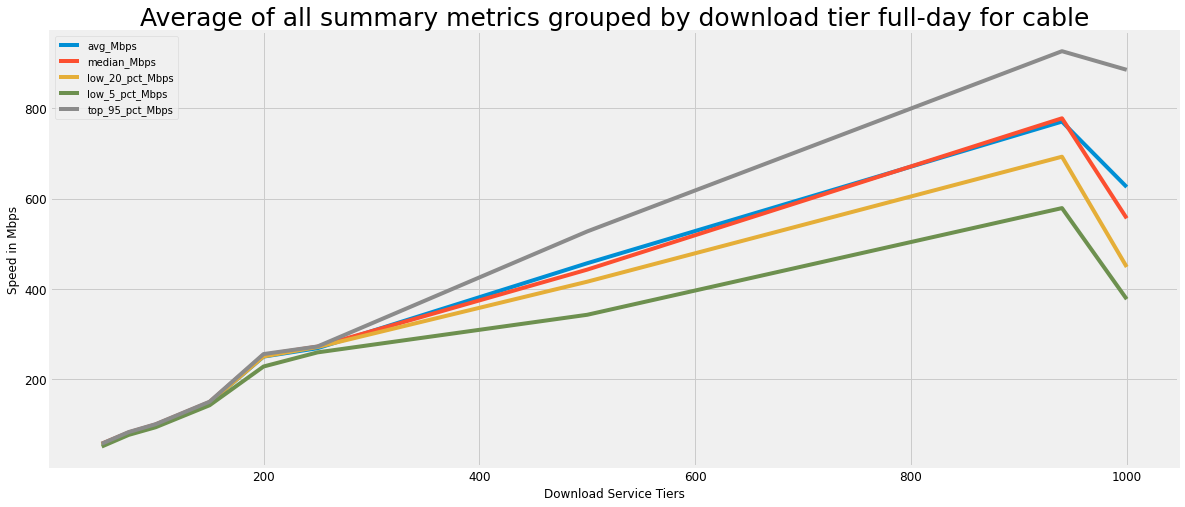

In [279]:
chartData = fullDay_download.where(fullDay_download.tech == 'Fiber').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for fiber', fontsize=25)
chartData

<h5> Peak vs full-day download metrics for DSL

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,low_4_percent_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,,
1.5,1.210811,1.235936,0.672360,1.493808,1.064696,0.611152,1.934584,0.022072,0.257870,65.000000
3.0,2.474551,2.609416,0.950392,3.675646,1.802474,0.916676,4.162190,0.107048,0.802581,28.000000
4.0,4.015566,4.367472,2.188920,4.414664,3.827016,2.066928,4.609920,0.305016,0.728208,18.000000
5.0,3.735885,4.216632,1.242880,4.329480,3.228968,1.103880,41.034560,0.249400,1.448880,49.000000
6.0,5.716059,5.834032,3.257440,7.379660,5.097612,3.043580,8.248776,0.327432,1.221353,23.000000
7.0,7.090968,7.221384,4.771928,8.535000,5.890320,4.653488,101.038368,1.884872,3.908118,28.000000
8.0,7.063737,7.463440,4.764104,9.892416,5.701512,4.558488,9.930472,1.966432,1.448562,19.000000
10.0,8.965091,9.273293,6.081445,10.711811,8.016531,5.580453,12.349453,1.337739,1.559577,45.666667
12.0,12.383266,12.340800,8.411643,15.845421,10.917768,7.794173,17.910112,0.830243,2.422858,60.666667


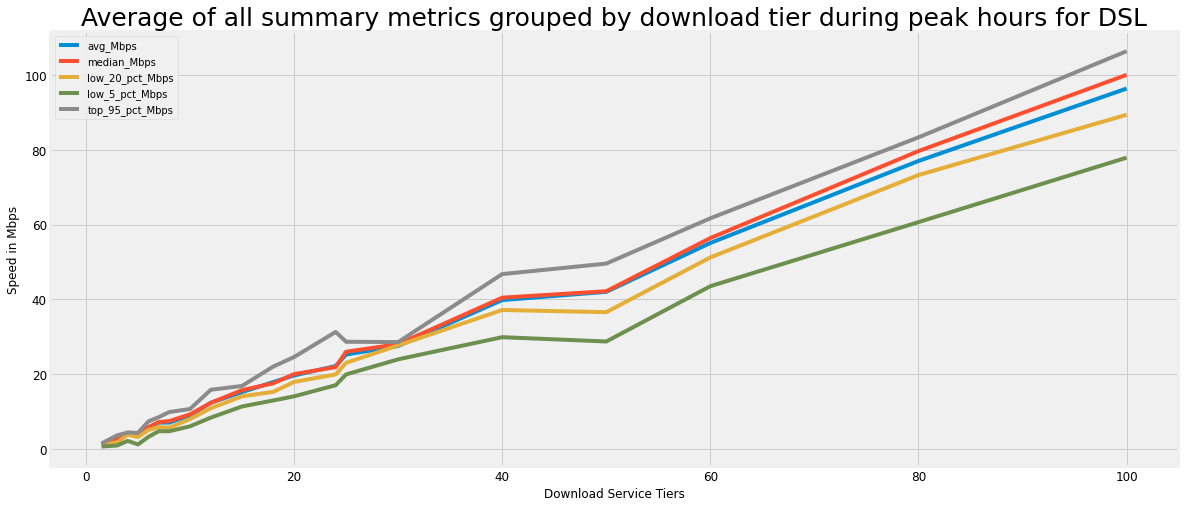

In [285]:
chartData = peak_download.where(peak_download.tech == 'DSL').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier during peak hours for DSL', fontsize=25)

chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
download_service_tier,,,,,,,,,
1.5,1.245270,1.249120,0.770912,1.523976,1.113936,1.964504,0.002232,0.245167,65.000000
3.0,2.613610,2.711582,1.120534,3.852208,1.973292,5.360682,0.076556,0.803153,28.000000
4.0,4.093838,4.373088,2.500536,4.421616,3.961888,4.756280,0.305016,0.651890,18.000000
5.0,3.710901,4.235648,1.277048,4.711584,2.968208,41.747272,0.110608,1.217759,49.000000
6.0,5.959831,5.893572,4.245108,7.763768,5.429672,8.256256,0.109228,1.064791,23.000000
7.0,5.908669,6.480244,3.790952,7.595844,4.348472,53.880400,1.742348,1.851109,20.000000
8.0,7.195517,7.664568,4.963528,9.794136,6.003136,10.034440,0.120664,1.373055,19.000000
10.0,9.177605,9.542744,6.746088,10.784371,8.341539,12.378859,0.969763,1.419988,46.666667
12.0,12.459315,12.364589,8.770888,15.670323,10.947555,17.944275,0.181960,2.352374,61.000000


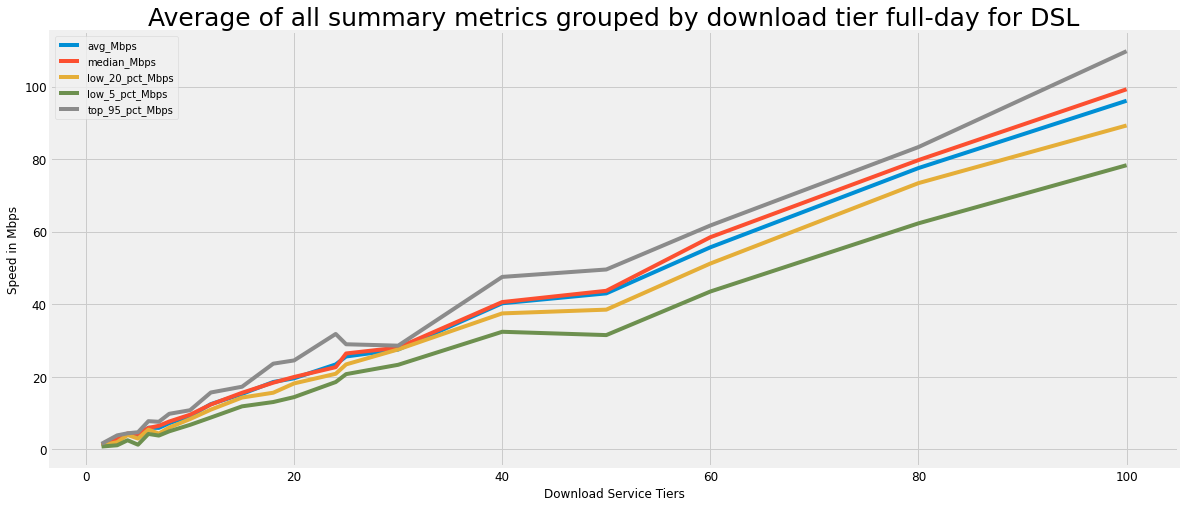

In [286]:
chartData = fullDay_download.where(fullDay_download.tech == 'DSL').groupby(['download_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by download tier full-day for DSL', fontsize=25)
chartData

<h2>Charts w/ average summary stats grouped by upload tier and technology</h2>

<h5> Peak vs full-day upload metrics for Cable

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
2.0,2.299681,2.324876,2.071264,2.455992,2.226140,2.642548,1.337836,0.134220,21.500000
3.0,3.163031,3.191536,2.987416,3.279968,3.149600,3.568224,0.713536,0.211641,52.000000
4.0,4.473288,4.518312,4.116912,4.670400,4.416240,4.802392,2.699360,0.210414,14.000000
5.0,5.921169,5.790389,4.976136,7.526621,5.642952,20.358139,1.216800,1.033882,85.666667
10.0,11.116663,11.037378,9.421658,12.806924,10.807038,13.691042,0.990650,1.230362,85.500000
15.0,17.247182,17.407552,16.229544,17.866872,17.274408,18.113776,8.254960,0.981138,36.000000
20.0,22.745217,23.265315,18.766341,24.888219,22.195771,25.756872,1.825317,2.484393,56.333333
30.0,29.497175,30.608908,16.433264,32.814808,29.615772,35.191092,0.618452,5.287943,42.000000
35.0,34.353309,36.523643,21.993152,39.511051,32.247128,40.596347,1.538795,5.945530,73.666667


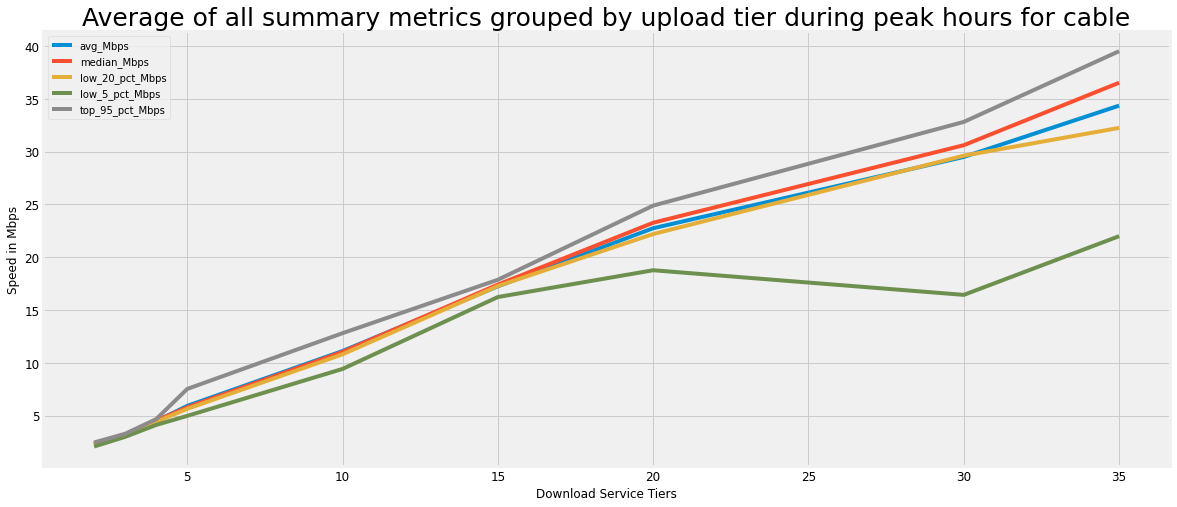

In [283]:
chartData = peak_upload.where(peak_upload.tech == 'Cable').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for cable', fontsize=25)
chartData


,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
2.0,2.306709,2.331848,2.094456,2.451996,2.237448,2.642548,0.625672,0.123543,21.500000
3.0,3.169538,3.196968,2.999656,3.278808,3.152980,3.689004,0.320844,0.201383,52.000000
4.0,4.516048,4.540680,4.284600,4.672648,4.441024,4.985816,2.469416,0.164288,14.000000
5.0,5.958213,5.797451,5.087248,7.542341,5.659024,319.575693,0.263629,2.278568,87.000000
10.0,11.174141,11.046244,10.095544,12.846942,10.836362,13.895476,0.265682,1.231558,85.750000
15.0,17.135553,17.394768,15.552040,17.868032,17.196776,18.192976,0.034672,1.311346,37.000000
20.0,22.861196,23.240883,20.359000,24.851891,22.268597,25.935571,0.571864,2.287004,57.000000
30.0,29.872871,30.538876,23.872140,33.066164,29.651456,35.434148,0.121348,4.478685,42.000000
35.0,34.630785,36.582568,21.899344,39.518973,33.713397,40.711653,0.911488,5.789238,74.333333


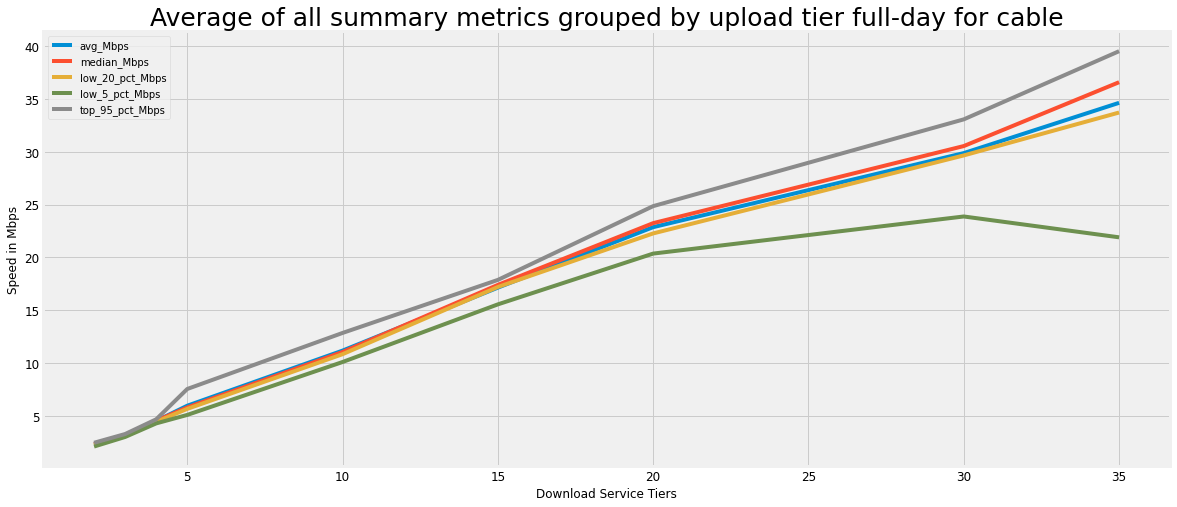

In [284]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Cable').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for cable', fontsize=25)
chartData

<h5> Peak vs full-day upload metrics for Fiber

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
50.0,60.500305,61.807192,54.115424,66.561324,55.566880,70.588612,34.310324,4.507544,38.000000
75.0,82.170666,85.841364,69.752068,90.607012,73.443004,93.856360,11.660144,8.067000,46.500000
100.0,110.869387,113.017619,101.844099,115.844733,107.179064,124.497261,38.218875,7.197155,53.666667
125.0,131.743156,132.010248,129.681488,135.662160,131.742496,217.946792,42.301848,7.668349,141.000000
150.0,151.001414,150.972808,149.375568,163.936200,150.727904,164.654520,0.497000,18.634483,25.000000
200.0,260.177129,267.837164,224.012344,288.452568,250.013068,293.859484,92.682436,25.924817,28.500000
500.0,505.554735,507.383752,455.543472,555.885832,493.525816,563.177928,144.816160,44.507128,69.000000
880.0,893.885556,921.215120,768.758080,938.763896,884.503528,940.378816,40.312256,92.184092,92.000000
1000.0,859.539908,914.827228,475.643972,934.498820,840.568468,941.472604,298.332304,134.434260,45.500000


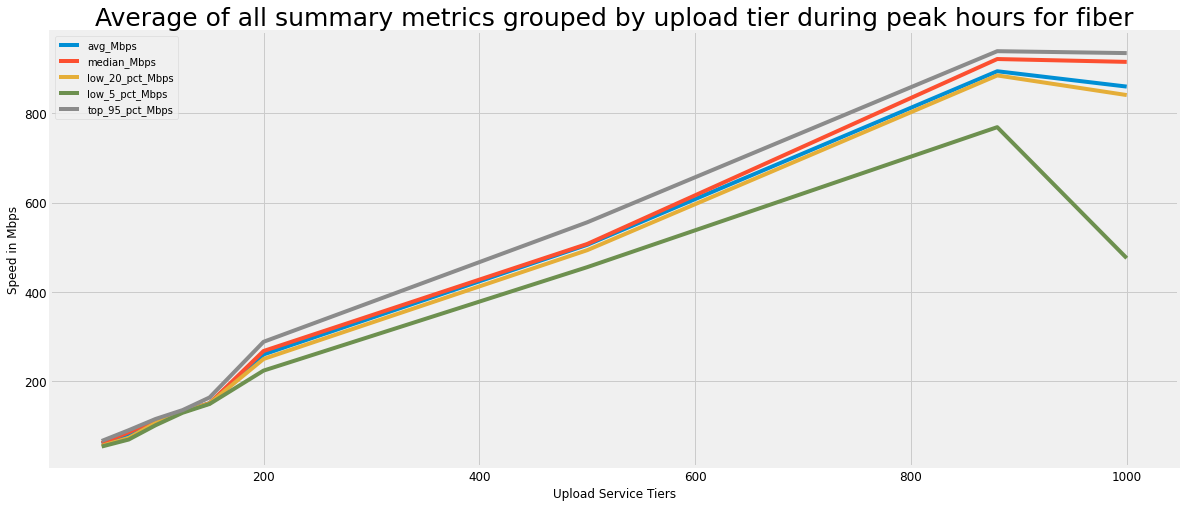

In [296]:
chartData = peak_upload.where(peak_upload.tech == 'Fiber').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for fiber', fontsize=25)
chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
50.0,60.538715,61.863968,54.144536,66.645696,55.527280,70.592560,31.085584,4.428535,38.5
75.0,82.588335,85.746872,70.446132,90.701088,74.026232,93.859288,11.660144,7.607434,46.5
100.0,110.652711,113.048816,104.062517,115.766893,106.510832,124.879736,16.948451,6.889878,54.0
125.0,131.809241,131.971880,130.204128,135.611904,131.746424,217.946792,1.543152,7.073977,141.0
150.0,146.476894,150.987464,143.946032,163.664880,150.708296,164.726768,0.497000,29.782761,25.0
200.0,261.585843,268.150884,220.351944,290.657068,259.829856,294.045596,48.755104,26.519372,29.0
500.0,503.450266,505.805808,426.520264,555.887728,496.665304,563.450880,137.499112,44.367938,70.0
880.0,894.013193,922.460912,759.728760,938.792448,885.764160,941.464352,2.935952,94.825991,94.0
1000.0,865.102589,924.679852,570.522680,934.662344,846.404096,941.472604,224.854700,132.659614,45.5


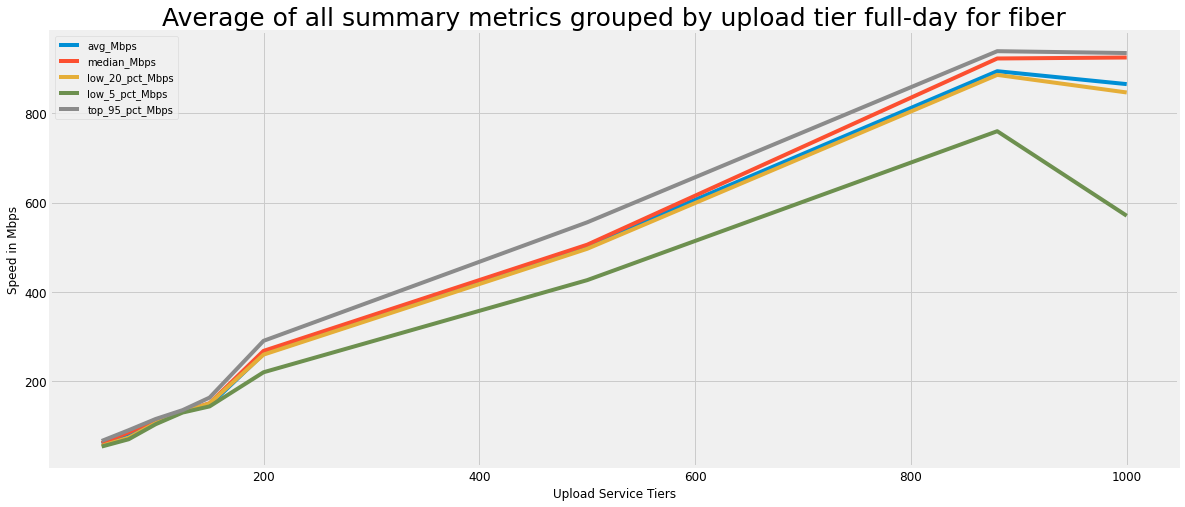

In [294]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'Fiber').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for fiber', fontsize=25)
chartData

<h5> Peak vs full-day upload metrics for DSL

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
0.256,0.192903,0.203536,0.099544,0.244552,0.150984,0.471552,0.027848,0.058068,20.0
0.384,0.507050,0.554656,0.149840,0.697880,0.345584,0.737888,0.135312,0.183899,13.0
0.512,0.268957,0.216960,0.115192,0.530584,0.156576,0.778400,0.048608,0.145785,51.0
0.640,0.620457,0.632440,0.463008,0.763768,0.529000,0.839800,0.139792,0.097842,22.0
0.750,0.647166,0.675512,0.204672,0.850264,0.589400,1.014456,0.037072,0.160779,34.0
0.768,0.593715,0.617146,0.356371,0.765224,0.489203,1.279141,0.126334,0.133574,42.2
0.896,0.720217,0.705520,0.507744,0.883760,0.629648,101.051776,0.178928,1.285278,133.0
1.000,0.903751,0.864696,0.605472,1.431900,0.720090,1.667038,0.216320,0.255145,57.5
1.500,1.377577,1.367435,0.872979,1.974275,1.093627,2.327915,0.342581,0.350394,63.0


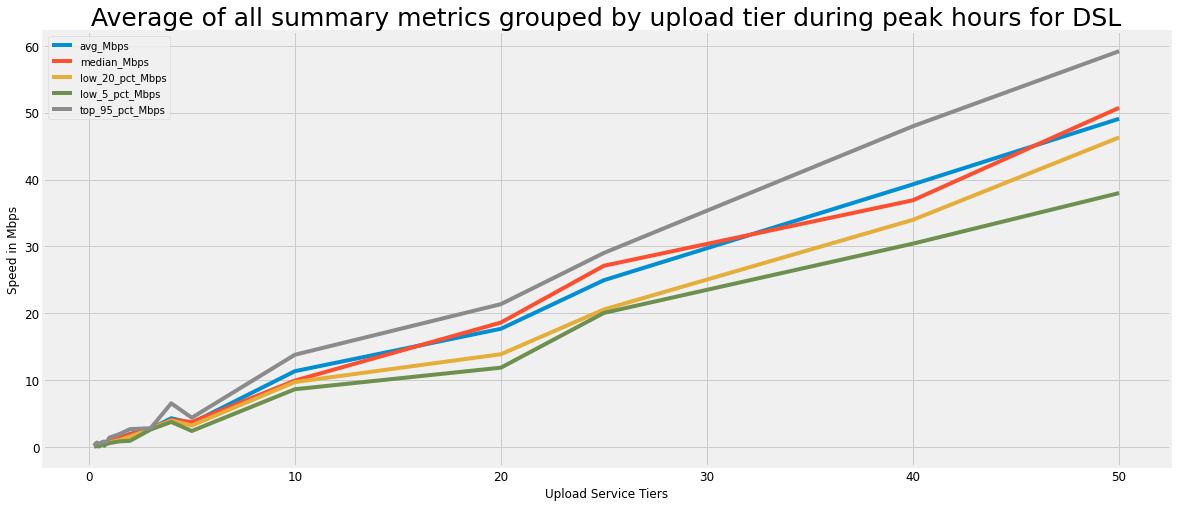

In [292]:
chartData = peak_upload.where(peak_upload.tech == 'DSL').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier during peak hours for DSL', fontsize=25)
chartData

,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes
upload_service_tier,,,,,,,,,
0.256,0.190928,0.203528,0.101776,0.248280,0.147624,0.493216,0.018472,0.055637,20.0
0.384,0.532650,0.571720,0.200184,0.698992,0.354528,0.737888,0.070448,0.167175,13.0
0.512,0.329353,0.298600,0.119656,0.664328,0.177320,0.778400,0.031280,0.164379,51.0
0.640,0.635622,0.641952,0.473080,0.785912,0.561432,0.869752,0.123016,0.095204,22.0
0.750,0.669256,0.687808,0.228152,0.904704,0.598344,1.014456,0.003352,0.161193,35.0
0.768,0.590015,0.606597,0.363672,0.762766,0.480706,1.335269,0.085002,0.132417,42.6
0.896,0.710113,0.706824,0.508440,0.883576,0.634128,101.051776,0.053680,0.728985,134.0
1.000,0.899041,0.866064,0.641200,1.361475,0.729955,1.644744,0.179562,0.229126,48.6
1.500,1.412395,1.442184,0.872709,2.064637,1.107147,2.336312,0.341091,0.369189,63.0


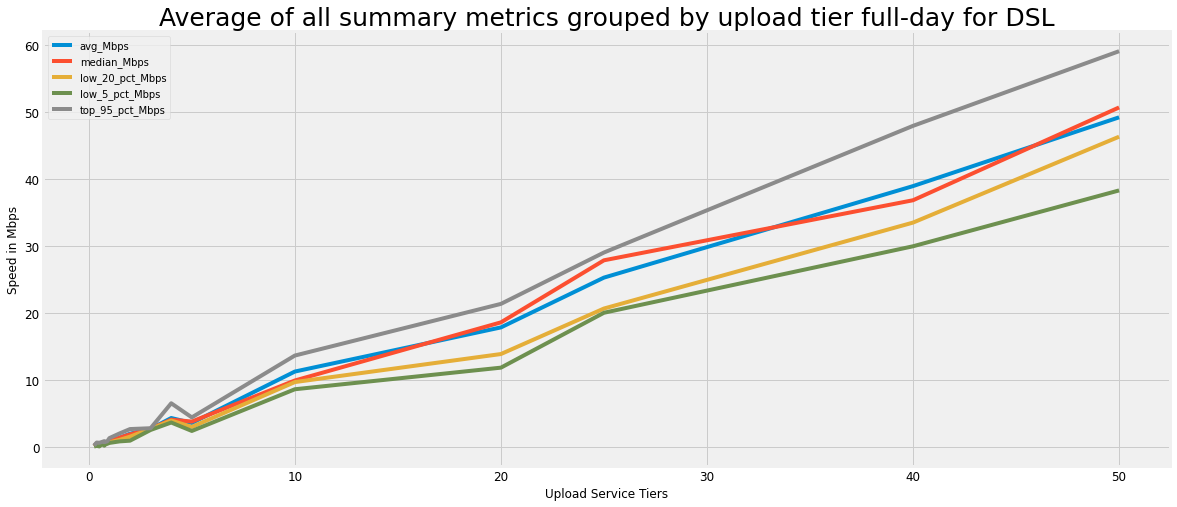

In [291]:
chartData = fullDay_upload.where(fullDay_upload.tech == 'DSL').groupby(['upload_service_tier']).mean()

ax = chartData.plot(y = ['avg_Mbps', 'median_Mbps', 'low_20_pct_Mbps', 'low_5_pct_Mbps', 'top_95_pct_Mbps'],
               fontsize = 12, figsize = (18,8))

x = np.arange(0,1025,25)

ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps')
ax.set_title('Average of all summary metrics grouped by upload tier full-day for DSL', fontsize=25)
chartData